In [88]:
import sys
print('python', sys.version)

import numpy as np
print('numpy', np.__version__)

import pandas as pd
print('pandas', pd.__version__)

import matplotlib as mpl
print('matplotlib', mpl.__version__)

import matplotlib.pyplot as plt
import scipy.stats as sci
import glob

import seaborn as sns

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

python 3.8.3 (default, Jul  2 2020, 17:30:36) [MSC v.1916 64 bit (AMD64)]
numpy 1.19.1
pandas 1.1.1
matplotlib 3.3.1


In [89]:
df_misl=pd.read_table('eval_result/MISL_results.txt',sep='\t', index_col=0)
df_misl['GS_data']='MISL'

df_syn=pd.read_table('eval_result/synlethDB_results.txt',sep='\t', index_col=0)
df_syn['GS_data']='synlethDB'

res_df=pd.concat([df_misl, df_syn])

def f1(row):
    rec=row['HIT']/row['GS']
    prc=row['HIT']/row['SP']
    fsc=(2*prc*rec)/(prc+rec)
    return pd.Series({'rec':rec,'prc':prc,'fsc':fsc})

rec_prc_fsc=res_df.apply(f1, axis=1)
res_df=pd.concat([res_df,rec_prc_fsc], axis=1)

def f2(row):
    if row['NET']!=row['NET']:
        return row['screening'] + ' ' + row['zero_exp']
    else:
        return row['screening'] + ' ' + row['NET'] + ' ' + row['RP']
    
res_df['set']=res_df.apply(f2, axis=1)

res_df=res_df.melt(id_vars=['GS_data','set'], value_vars=['rec','prc','fsc'], var_name='eval_method',value_name='eval_score')
res_df=res_df.rename(columns={'GS_data':'GS'})
res_df

,GS,set,eval_method,eval_score
0,MISL,CRISPER IZ,rec,0.000105
1,MISL,CRISPER EZ,rec,0.000106
2,MISL,CRISPER KEGG it,rec,0.000047
3,MISL,CRISPER KEGG d2,rec,0.000035
4,MISL,CRISPER KEGG d1,rec,0.000035
...,...,...,...,...
91,synlethDB,shRNA KEGG d2,fsc,0.001066
92,synlethDB,shRNA KEGG d1,fsc,0.001067
93,synlethDB,shRNA PPI it,fsc,0.002069
94,synlethDB,shRNA PPI d2,fsc,0.002077


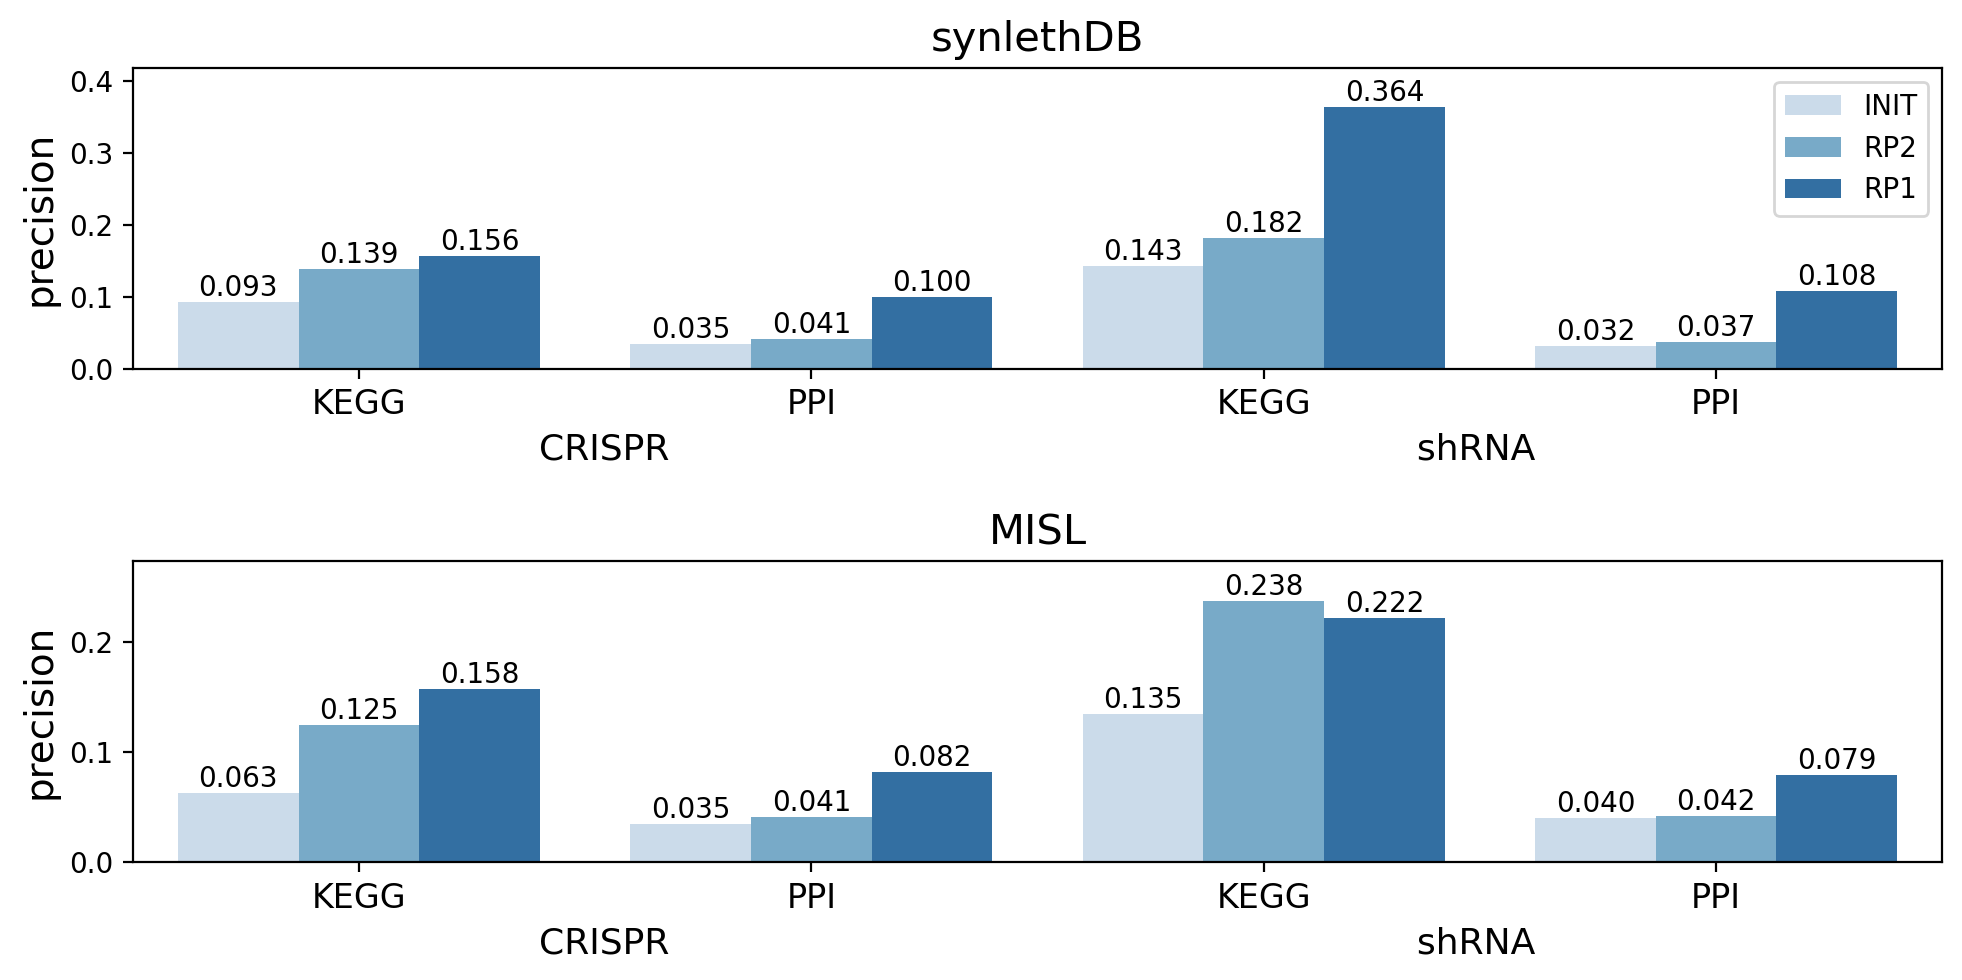

In [100]:
sym2sym={'it':'INIT','d2':'RP2','d1':'RP1'}
def draw_precision_bargraph(res_df, GS, ax):
    res_net=res_df.loc[(res_df['eval_method']=='prc')&
                       (~res_df['set'].str.contains('IZ|EZ'))&
                       (res_df['GS']==GS)].copy()
    
    res_net['ref']=res_net['set'].map(lambda x: sym2sym[x.split(' ')[-1]])
    res_net['set']=res_net['set'].map(lambda x: '/'.join(x.split(' ')[:2]))
    res_net.drop(columns=['eval_method','GS'],inplace=True)
    res_net.columns=['screening/network','precision','Refining Process']

    sns.barplot(data=res_net, x='screening/network', y='precision', hue='Refining Process', ax=ax, palette='Blues')

    W=[patch.get_width() for patch in ax.patches][0]
    for ind in range(len(res_net)):
        xpos=(ind//3)+((ind%3)-1)*W
        prc = res_net.iloc[ind]["precision"]
        _=ax.text(x=xpos, y=prc, s='{:.3f}'.format(prc), ha='center', va='bottom')
 
    ax.set_ylim(0,res_net['precision'].max()*1.15)
    
    ax.set_title(GS, fontsize=15)
    ax.set_ylabel(ax.get_ylabel(), fontsize=14)
    
    ax.set_xlabel('CRISPR                                                                 shRNA', fontsize=13)
    ax.set_xticklabels([x.get_text().split('/')[1] for x in ax.get_xticklabels()], fontsize=12)
    ax.legend(bbox_to_anchor=(1, 1), loc='upper right')
    
fig=plt.figure(figsize=(10,5), dpi=200)
(ax1, ax2)=fig.subplots(2,1)
draw_precision_bargraph(res_df, 'synlethDB', ax1)
draw_precision_bargraph(res_df, 'MISL', ax2)
ax2.get_legend().remove()
fig.tight_layout(h_pad=1.7)
fig.savefig('eval_result_RP.jpeg', dpi=200)

In [20]:
res_df

,GS,set,eval_method,eval_score
0,MISL,CRISPER IZ,rec,0.000105
1,MISL,CRISPER EZ,rec,0.000106
2,MISL,CRISPER KEGG it,rec,0.000047
3,MISL,CRISPER KEGG d2,rec,0.000035
4,MISL,CRISPER KEGG d1,rec,0.000035
...,...,...,...,...
91,synlethDB,shRNA KEGG d2,fsc,0.001066
92,synlethDB,shRNA KEGG d1,fsc,0.001067
93,synlethDB,shRNA PPI it,fsc,0.002069
94,synlethDB,shRNA PPI d2,fsc,0.002077


               GS/scr    EP  eval_score
0        MISL_CRISPER  SGOE    0.000105
1        MISL_CRISPER  SGWE    0.000106
8          MISL_shRNA  SGOE    0.000261
9          MISL_shRNA  SGWE    0.000261
16  synlethDB_CRISPER  SGOE    0.000843
17  synlethDB_CRISPER  SGWE    0.000875
24    synlethDB_shRNA  SGOE    0.001186
25    synlethDB_shRNA  SGWE    0.001203
               GS/scr    EP  eval_score
32       MISL_CRISPER  SGOE    0.023136
33       MISL_CRISPER  SGWE    0.021531
40         MISL_shRNA  SGOE    0.019268
41         MISL_shRNA  SGWE    0.020833
48  synlethDB_CRISPER  SGOE    0.020566
49  synlethDB_CRISPER  SGWE    0.019139
56    synlethDB_shRNA  SGOE    0.017341
57    synlethDB_shRNA  SGWE    0.018750


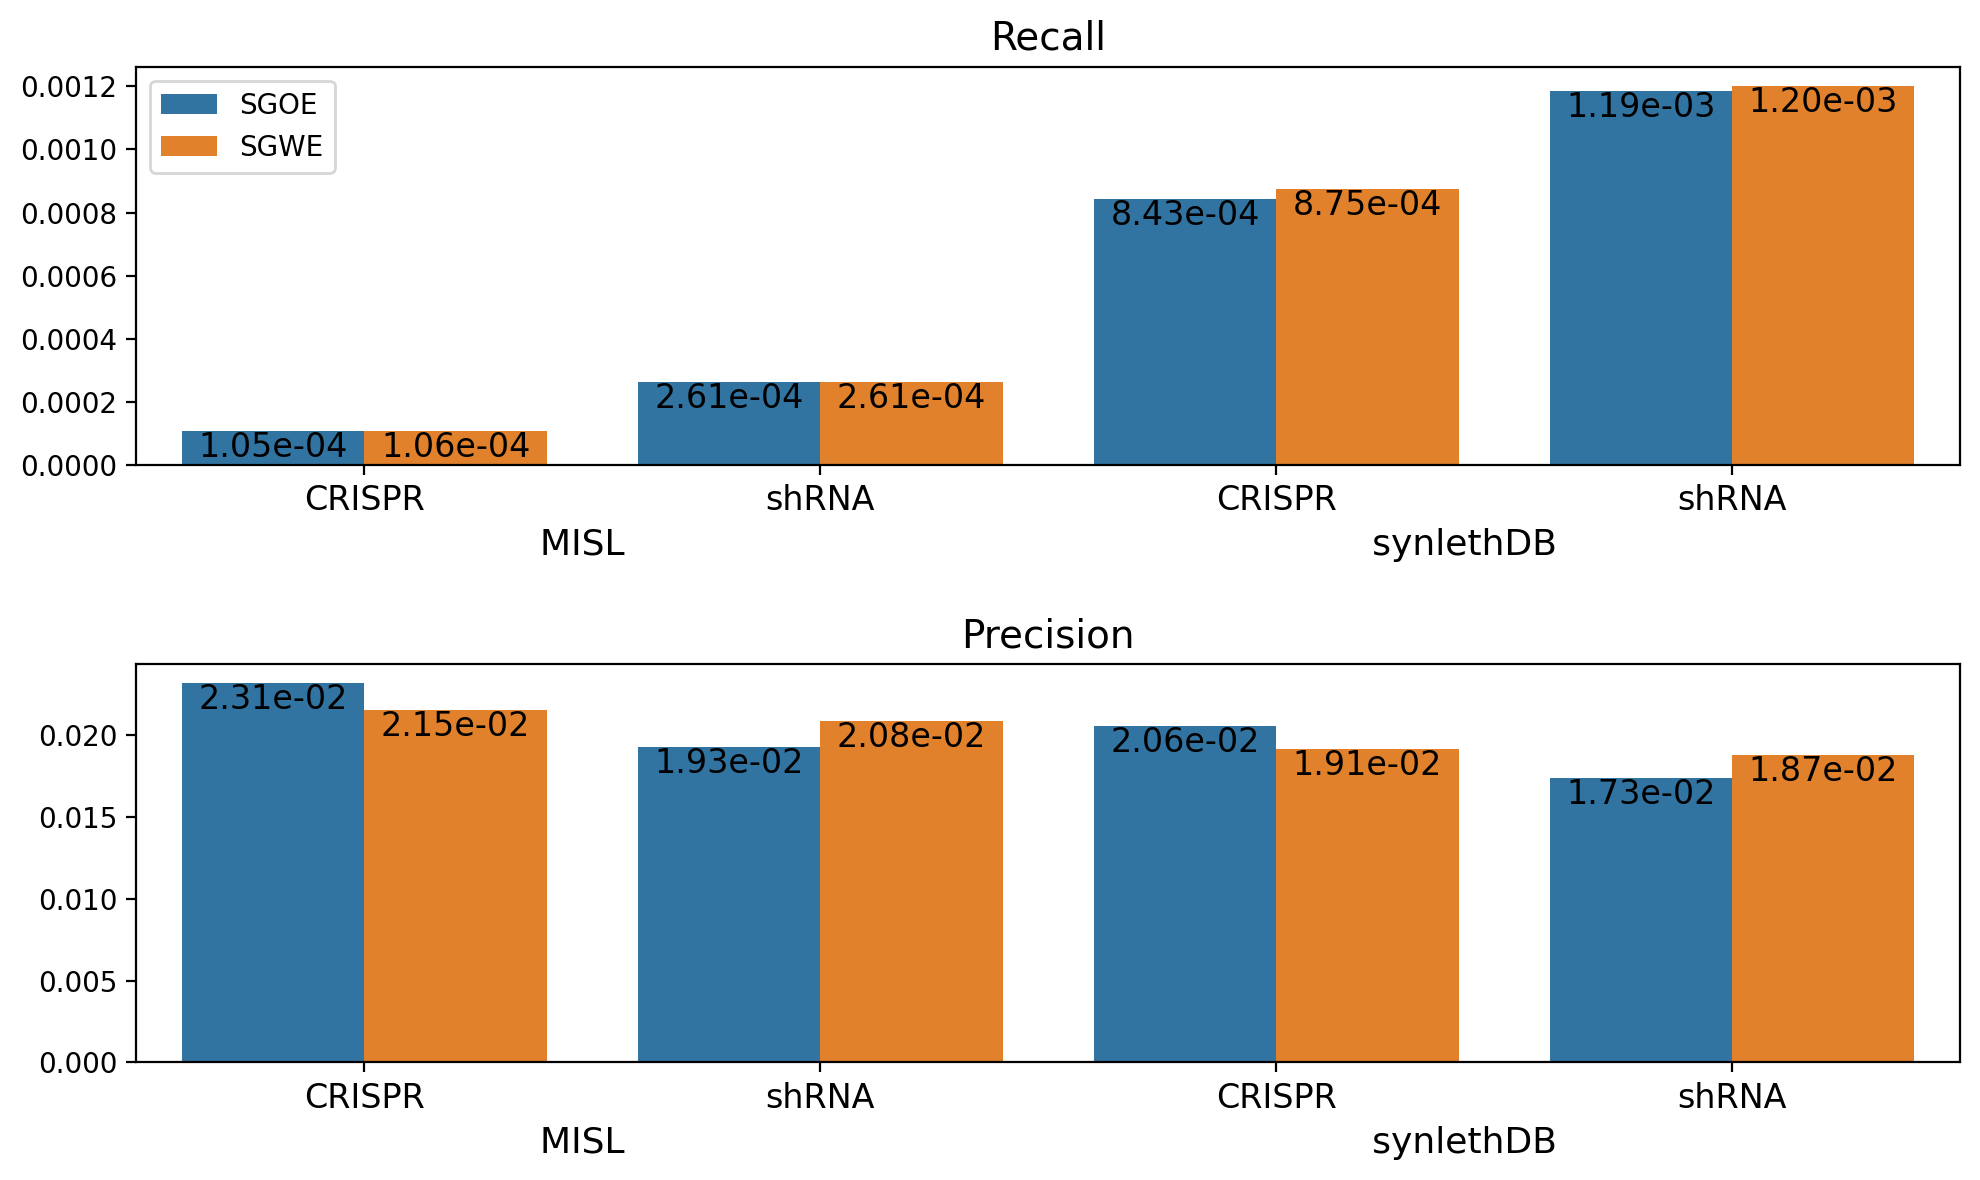

In [87]:
sym2sym={'it':'INIT.','d2':'DST=2','d1':'DST=1'}
def draw_IZEZ_bargraph(res_df, eval_method, ax):
    res_net=res_df.loc[(res_df['set'].str.contains('IZ|EZ'))&
                       (res_df['eval_method']==eval_method)].copy()

    res_net[['screening','EP']]=res_net['set'].str.split(' ',expand=True)
    res_net['GS/scr']=res_net['GS']+'_'+res_net['screening']
    res_net.drop(columns=['eval_method','GS','screening','set'],inplace=True)
    
    res_net=res_net[['GS/scr','EP','eval_score']]
    res_net['EP']=res_net['EP'].str.replace('EZ','SGWE').str.replace('IZ','SGOE')
    print(res_net)
    
    sns.barplot(data=res_net, x='GS/scr', y='eval_score', hue='EP', ax=ax)
    ax.set_title({'rec':'Recall','prc':'Precision'}[eval_method], fontsize=14)
    
    ax.set_xticklabels([x.get_text().split('_')[1].replace('CRISPER','CRISPR') for x in ax.get_xticklabels()], fontsize=12)
    ax.set_xlabel('MISL                                                                 synlethDB', fontsize=13)

    ax.legend(bbox_to_anchor=(0, 1), loc='upper left')

    for ind,xpos in zip(range(len(res_net)),[-0.2,0.2,0.8,1.2,1.8,2.2,2.8,3.2]):
        prc = res_net.iloc[ind]["eval_score"]
        _=ax.text(x=xpos, y=prc, s='{:.2e}'.format(prc), ha='center', va='top', fontsize=12)
    
    ax.set_ylabel('')
    
fig=plt.figure(figsize=(10,6), dpi=200)
(ax1, ax2)=fig.subplots(2,1)

draw_IZEZ_bargraph(res_df, 'rec', ax1)
draw_IZEZ_bargraph(res_df, 'prc', ax2)

ax2.get_legend().remove()
fig.tight_layout(h_pad=2)

fig.savefig('eval_result_SGWE.jpeg', dpi=200)